In [1]:
import sys
import time
sys.path.append('/home/kevinteng/Desktop/BrainTumourSegmentation')
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import os, random
import utils
from utils_vis import plot_comparison, plot_labels_color, plot_loss
from utils import compute_metric_dc
import nibabel as nib
from sklearn.model_selection import KFold
%matplotlib inline

- Blue => Label 1 (Necrotic and Non-enhancing Tumor Core)
- Yellow => Label 2 (Peritumoral Edema)
- Green => Label 3/4 (GD-Enhancing Tumor)
---
* Core => Label 1 & 3
* Enhancing => Label 3
* Complete => Label 1,2, 3

---

# Hyperparameter

In [2]:
SHUFFLE_BUFFER = 4000
BATCH_SIZE = 8
lr = 0.0001
opt = tf.keras.optimizers.Adam(lr)
ver = 'model_self_attention_06' #save version
dropout=0.2 #dropout rate
hn = 'he_normal' #kernel initializer 
tfrecords_read_dir = '/home/kevinteng/Desktop/ssd02/BraTS20_tfrecords05/'
stack_npy = "/home/kevinteng/Desktop/ssd02/BraTS2020_stack05/"

---

# Helper Functions

In [3]:
xent = tf.keras.losses.CategoricalCrossentropy()

def generalized_dice(y_true, y_pred, smooth = 1e-5):
    """
    Generalized Dice Score
    https://arxiv.org/pdf/1707.03237
    https://github.com/Mehrdad-Noori/Brain-Tumor-Segmentation/blob/master/loss.py
    """
    
    y_true    = tf.reshape(y_true,shape=(-1,4))
    y_pred    = tf.reshape(y_pred,shape=(-1,4))
    sum_p     = tf.reduce_sum(y_pred, -2)
    sum_r     = tf.reduce_sum(y_true, -2)
    sum_pr    = tf.reduce_sum(y_true * y_pred, -2)
    weights   = tf.math.pow(tf.math.square(sum_r) + smooth, -1)
    generalized_dice = (2 * tf.reduce_sum(weights * sum_pr)) / (tf.reduce_sum(weights * (sum_r + sum_p)))
    return generalized_dice

def generalized_dice_loss(y_true, y_pred):   
    return 1-generalized_dice(y_true, y_pred)
    
def custom_loss(y_true, y_pred):
    
    """
    The final loss function consists of the summation of two losses "GDL" and "CE"
    with a regularization term.
    """
    
    return generalized_dice_loss(y_true, y_pred) + 1.25 * xent(y_true, y_pred)

def data_aug(imgs):
    choice = np.random.randint(0,4)
    #no augmentation 
    if choice==0:
        x = imgs 
    #flip up and down 
    if choice==1:
        x = tf.image.flip_up_down(imgs)
    #flip left and right 
    if choice==2:
        x = tf.image.flip_left_right(imgs)
    #rotation based on angle 
    if choice==3:
        n_rot = np.random.randint(1,4)
        x = tf.image.rot90(imgs, k=n_rot)
    return x

---

# Layer Names

In [4]:
# template for guided attention block
layer_name_p01 = ['pam01_conv01', 'pam01_conv02', 'pam01_softmax', 'pam01_conv03',
                  'pam01_alpha','pam01_add']
layer_name_c01 = ['cam01_softmax', 'cam01_alpha','cam01_add']
layer_name_p02 = ['pam02_conv01', 'pam02_conv02', 'pam02_softmax', 'pam02_conv03',
                  'pam02_alpha', 'pam02_add']
layer_name_c02 = ['cam02_softmax', 'cam02_alpha','cam02_add']
layer_name_template = [layer_name_p01, layer_name_c01, layer_name_p02, layer_name_c02]

layer_name_ga = []
for b in range(1,4):
    layer_block = []
    for layer in layer_name_template:
        layer_internal = [i+'block0{}'.format(b) for i in layer]
        layer_block.append(layer_internal)
    layer_name_ga.append(layer_block)

----

# Model

In [5]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Activation, Add, Multiply, GaussianNoise
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, Dropout, concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Layer, Softmax, ReLU, PReLU
from tensorflow_addons.layers import GroupNormalization
from utils_model import *
from attention import *

def guided_attention_block(inp_feature, layer_name_p, layer_name_c):
    '''
    Guided attention block that takes feature as input and concatenates features
    from PAM and CAM as output
    :param inp_feature: Input features
    :param layer_name_p: layer name list for PAM
    :param layer_name_c: layer name list for CAM
    :return: squeezed concatenated features of PAM and CAM
    '''
    pam_feature = PAM(inp_feature, layer_name_p, kernel_initializer=hn)
    cam_feature = CAM(inp_feature, layer_name_c)
    add = Add()([pam_feature,cam_feature]) #[60,60,128]
    up = UpSampling2D(size=(4,4))(add) #[240,240,128]
    squeeze = Conv2D(filters=64, kernel_size=1, padding='same', kernel_initializer=hn,
                       activation='relu')(up)
    #pam and cam features
    feature_pc = [pam_feature, cam_feature]
    return squeeze, feature_pc

def guided_attention(res_feature, ms_feature, layer_name):
    '''
    Guided attention module
    :param res_feature: Upsampled Feature maps from Res Block
    :param ms_feature: Multi scale feature maps result from Res Block
    :param layer_name: Layer Name should consist be a list contating 4 list
    Example:
    layer_name_p01 = ['pam01_conv01', 'pam01_conv02', 'pam01_softmax', 'pam01_conv03',
                      'pam01_alpha','pam01_add']
    layer_name_c01 = ['cam01_softmax', 'cam01_alpha','cam01_add']
    layer_name_p02 = ['pam02_conv01', 'pam02_conv02', 'pam02_softmax', 'pam02_conv03',
                      'pam02_alpha', 'pam02_add']
    layer_name_c02 = ['cam02_softmax', 'cam02_alpha','cam02_add']
    layer_name = [layer_name_p01, layer_name_c01, layer_name_p02, layer_name_c02]

    :return: guided attention module with shape same as input
    '''
    assert len(layer_name)==4, "Layer name should be a list consisting 4 lists!"
    #self attention block01
    concat01 = concatenate([res_feature, ms_feature], axis=-1)
    squeeze01, feature_pc01 = guided_attention_block(concat01, layer_name[0], layer_name[1])
    multi01 = Multiply()([squeeze01, ms_feature])
    #self attention block02
#     concat02 = concatenate([multi01, res_feature],axis=-1)
#     squeeze02 = guided_attention_block(concat02, layer_name[2], layer_name[3])
    return multi01, feature_pc01

def forward(x):
    '''
    Resnet as backbone for multiscale feature retrieval.
    Each resblock output(input signal), next resblock output(gated signal) is
    feed into the gated attention for multi scale feature refinement.
    Each gated attention output is pass through a bottle neck layer to standardize
    the channel size by squashing them to desired filter size of 64.
    The features are upsampled at each block to the corresponding [wxh] dimension
    of w:240, h:240.
    The upsampled features are concat and squash to corresponding channel size of 64
    which yield multiscale feature.
    :param x: batched images
    :return: feature maps of each res block
    '''
    #inject noise
    gauss1 = GaussianNoise(0.01)(x)
    #retrieve input dimension
    b,w,h,c = x.shape
    #---- ResNet and Multiscale Features----
    #1st block
    conv01 = CoordConv(x_dim=w, y_dim=h, with_r=False, filters=64, strides=(1,1),
                      kernel_size = 3, padding='same', kernel_initializer=hn, name='conv01')(gauss1)
    res_block01 = res_block_sep_v2(conv01, filters=[128, 64], layer_name=["conv02", "conv03", "add01"], dropout_rate=None)
    #2nd block
    down_01 = down_sampling_sep_v2(res_block01, filters=128, layer_name = 'down_01',  kernel_initializer=hn,
                               mode='coord',x_dim=w//2, y_dim=w//2)
    res_block02 = res_block_sep_v2(down_01, filters=[256, 128], layer_name=["conv04", "conv05", "add02"], dropout_rate=None)
    #3rd block
    down_02 = down_sampling_sep_v2(res_block02, filters=256, layer_name = 'down_02',  kernel_initializer=hn,
                               mode='coord',x_dim=w//4, y_dim=h//4)
    res_block03 = res_block_sep_v2(down_02, filters=[512, 256], layer_name=["conv06", "conv07", "add03"], dropout_rate=None)
    #4th block
    down_03 = down_sampling_sep_v2(res_block03, filters=512, layer_name = 'down_03',  kernel_initializer=hn,
                               mode='coord',x_dim=w//8, y_dim=h//8)
    res_block04 = res_block_sep_v2(down_03, filters=[1024, 512], layer_name=["conv08", "conv09", "add04"], dropout_rate=None)
    # *apply activation function for the last output
    res_block04 = PReLU(shared_axes=[1,2])(res_block04)
    #grid attention blocks
    att_block01, g_att01 = attention_block(res_block01,res_block02,64,'grid_att01')
    att_block02, g_att02 = attention_block(res_block02,res_block03,128,'grid_att02')
    att_block03, g_att03 = attention_block(res_block03, res_block04,256,'gird_att03')
    #bottle neck => layer squash all attention block to same filter size 64
    bottle01 = Conv2D(filters=64, kernel_size=1, padding='same', kernel_initializer=hn)(att_block01)
    bottle02 = Conv2D(filters=64, kernel_size=1, padding='same', kernel_initializer=hn)(att_block02)
    bottle03 = Conv2D(filters=64, kernel_size=1, padding='same', kernel_initializer=hn)(att_block03)
    #upsampling for all layers to same (wxh) dimension=>240x240
    up01 = bottle01 #[240,240,64]
    up02 = UpSampling2D(size=(2, 2), interpolation='bilinear')(bottle02) #[120,120,64]=>[240,240,64]
    up03 = UpSampling2D(size=(4,4), interpolation='bilinear')(bottle03) #[60,60,64]=>[240,240,64]
    #multiscale features
    concat_all = concatenate([up01,up02,up03],axis=-1) #[240,240,3*64]
    #squeeze to have the same channel as upsampled features [240,240,3*64] => [240,240,64]
    ms_feature = Conv2D(filters=64, kernel_size=1, padding='same', kernel_initializer=hn)(concat_all)
    #Segmentations from multiscale features *without softmax activation
    seg_01 = Conv2D(4, (1,1), name='seg_01')(up01)
    seg_02 = Conv2D(4, (1,1), name='seg_02')(up02)
    seg_03 = Conv2D(4, (1,1), name='seg_03')(up03)

    #----self guided attention blocks-----
    ga_01, f_pc01 = guided_attention(up01, ms_feature, layer_name_ga[0])
    ga_02, f_pc02 = guided_attention(up02, ms_feature, layer_name_ga[1])
    ga_03, f_pc03 = guided_attention(up03, ms_feature, layer_name_ga[2])
    #Segmentations from guided attention features *without softmax activation
    seg_ga01 = Conv2D(4, (1,1), name='seg_ga01')(ga_01)
    seg_ga02 = Conv2D(4, (1,1), name='seg_ga02')(ga_02)
    seg_ga03 = Conv2D(4, (1,1), name='seg_ga03')(ga_03)
    #outputs for xent losses
    output_xent = [seg_01, seg_02, seg_03, seg_ga01, seg_ga02, seg_ga03]
    #output for dice coefficient loss
    pred_seg = Add()(output_xent)
    output_dice = Softmax()(pred_seg/len(output_xent))
    #output for feature visualization 
    #gated attention 
    gated_attention = [g_att01, g_att02, g_att03]
    #pam and cam features
    f_pc = [f_pc01, f_pc02, f_pc03]
    return output_xent, output_dice, gated_attention, f_pc 

In [6]:
#Build Model
input_layer = Input(shape=(200,200,4))
model = Model(input_layer, forward(input_layer))

In [7]:
from loss_fn import *
xent_logit = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
focal_logit = SparseCategoricalFocalLoss(gamma=2, from_logits=True)

@tf.function
def train_fn(image, label):
    with tf.GradientTape() as tape:
        output_xent, output_dice, _, _ = model(image, training=True)
        loss_dice = generalized_dice_loss(label, output_dice)
        loss_xents=[]
        for seg in output_xent:
            l_xent = focal_logit(tf.math.argmax(label,-1,output_type=tf.int32), seg)
            loss_xents.append(l_xent)
        loss_xent = sum(loss_xents)
        loss_total = loss_xent+loss_dice
    gradients = tape.gradient(loss_total, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    losses = [loss_xent, loss_dice, loss_total]
    return output_dice, losses, gradients

---


Epochs  1



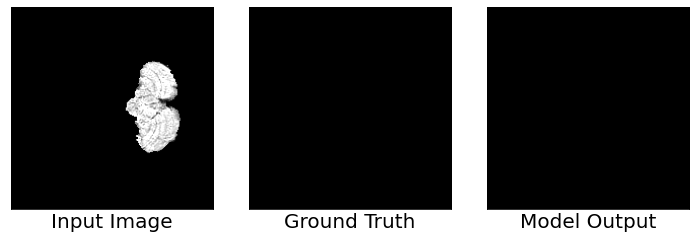

Steps: 5000, L_xent:0.10395851731300354, L_dice: 1.0
Total Loss: 1.1039584875106812
Accurary: 1.0
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 1.0]
Gradient min:-0.14922882616519928, max:0.11440915614366531
Compute time per epochs: 64.03 mins

Epochs  2



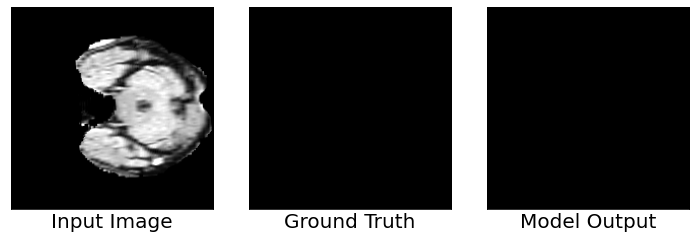

Steps: 5000, L_xent:0.02021711692214012, L_dice: 0.23881077766418457
Total Loss: 0.259027898311615
Accurary: 1.0
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 1.0]
Gradient min:-0.08940475434064865, max:0.11149892210960388
Compute time per epochs: 63.61 mins

Epochs  3



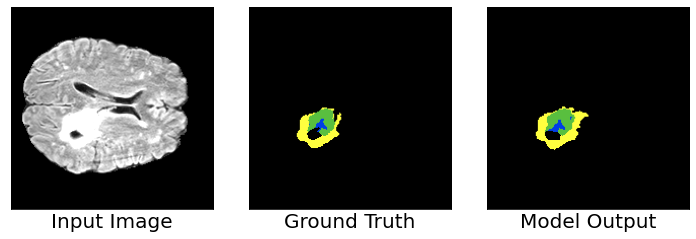

Steps: 5000, L_xent:0.19774958491325378, L_dice: 0.10952240228652954
Total Loss: 0.3072719871997833
Accurary: 0.9926999807357788
Seq: TC, ET, WT
Dice coefficient: [0.9805328139662742, 0.9897049376368523, 0.9666301828622818]
Gradient min:-0.05718475207686424, max:0.04224555194377899
Compute time per epochs: 63.45 mins

Epochs  4



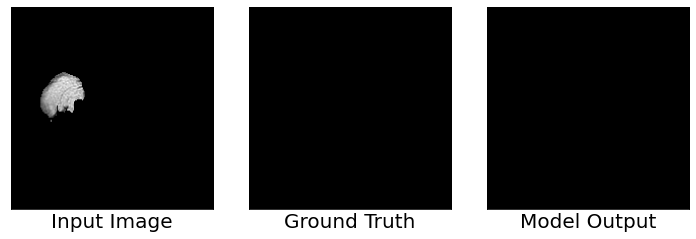

Steps: 5000, L_xent:0.03620128706097603, L_dice: 1.0
Total Loss: 1.0362012386322021
Accurary: 1.0
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 1.0]
Gradient min:-0.11179126054048538, max:0.052409540861845016
Compute time per epochs: 63.62 mins

Epochs  5



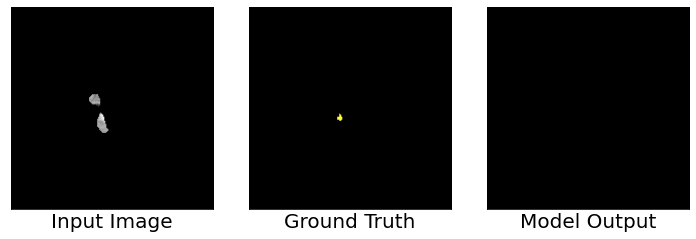

Steps: 5000, L_xent:0.03661957010626793, L_dice: 0.3037213683128357
Total Loss: 0.3403409421443939
Accurary: 0.9994500279426575
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 0.9883333333333333]
Gradient min:-0.14070214331150055, max:0.33895182609558105
Compute time per epochs: 77.74 mins

Epochs  6



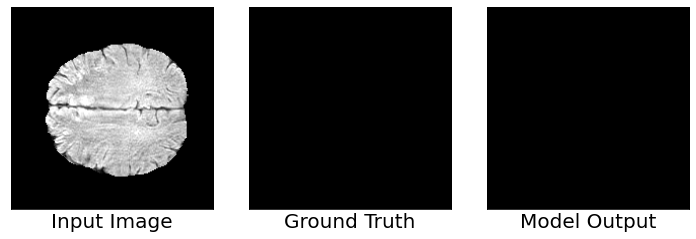

Steps: 5000, L_xent:0.12836232781410217, L_dice: 0.4537258744239807
Total Loss: 0.5820882320404053
Accurary: 1.0
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 1.0]
Gradient min:-0.22810956835746765, max:0.21875537931919098
Compute time per epochs: 63.64 mins

Epochs  7



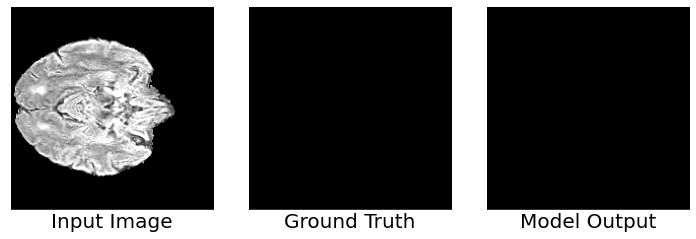

Steps: 5000, L_xent:0.042717017233371735, L_dice: 0.12852752208709717
Total Loss: 0.1712445318698883
Accurary: 1.0
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 1.0]
Gradient min:-0.03961162641644478, max:0.05041586235165596
Compute time per epochs: 63.41 mins

Epochs  8



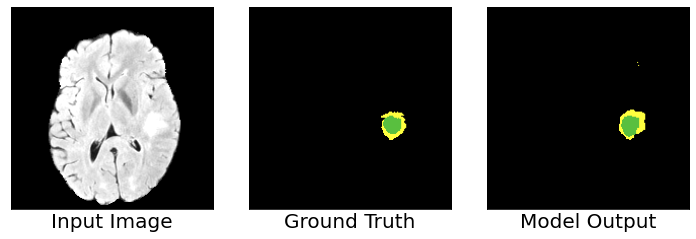

Steps: 5000, L_xent:0.09731562435626984, L_dice: 0.4032970666885376
Total Loss: 0.5006126761436462
Accurary: 0.9961249828338623
Seq: TC, ET, WT
Dice coefficient: [0.9888200472295284, 0.9776400944590569, 0.9730352717886368]
Gradient min:-0.31782853603363037, max:0.2734643220901489
Compute time per epochs: 63.62 mins

Epochs  9



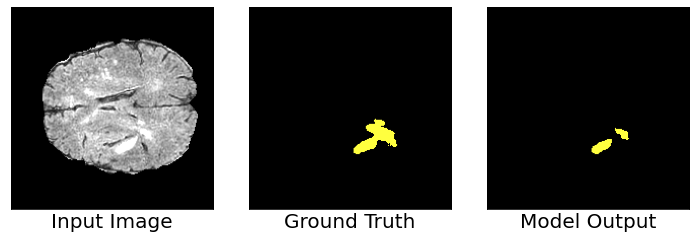

Steps: 5000, L_xent:0.078300841152668, L_dice: 0.12918347120285034
Total Loss: 0.20748430490493774
Accurary: 0.9902999997138977
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 0.9697251167893409]
Gradient min:-0.043768901377916336, max:0.044750478118658066
Compute time per epochs: 64.01 mins

Epochs 10



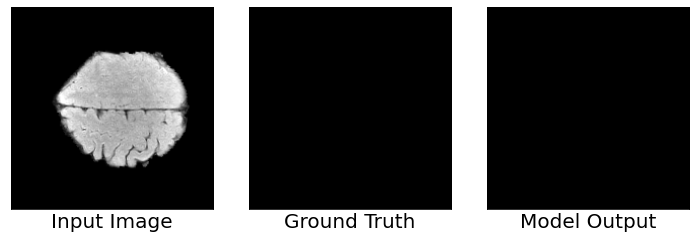

Steps: 5000, L_xent:0.058600928634405136, L_dice: 0.3385564684867859
Total Loss: 0.3971574008464813
Accurary: 1.0
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 1.0]
Gradient min:-0.04257671907544136, max:0.048427220433950424
Compute time per epochs: 77.65 mins

Epochs 11



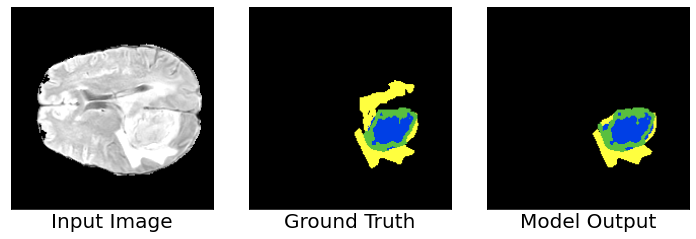

Steps: 5000, L_xent:0.09205813705921173, L_dice: 0.10420083999633789
Total Loss: 0.19625897705554962
Accurary: 0.9741500020027161
Seq: TC, ET, WT
Dice coefficient: [0.9773842003196478, 0.9759614777565002, 0.9110777857402961]
Gradient min:-0.11492332816123962, max:0.04344318062067032
Compute time per epochs: 63.50 mins

Epochs 12



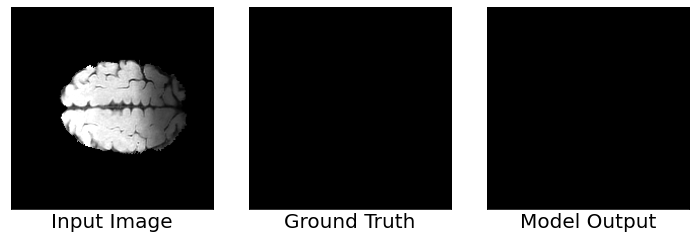

Steps: 5000, L_xent:0.1490456759929657, L_dice: 1.0
Total Loss: 1.149045705795288
Accurary: 1.0
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 1.0]
Gradient min:-0.156002938747406, max:0.09427859634160995
Compute time per epochs: 63.57 mins

Epochs 13



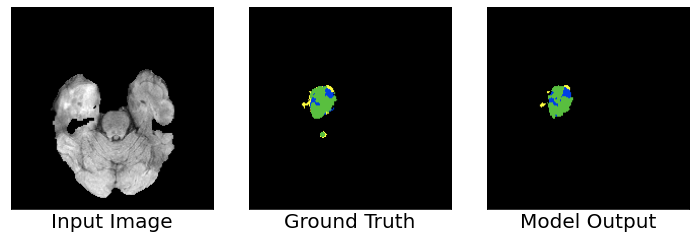

Steps: 5000, L_xent:0.23648665845394135, L_dice: 0.29947781562805176
Total Loss: 0.5359644889831543
Accurary: 0.9955750107765198
Seq: TC, ET, WT
Dice coefficient: [0.9409022670984268, 0.9509676054120064, 0.9179034040868282]
Gradient min:-0.3198074996471405, max:0.3459649085998535
Compute time per epochs: 63.81 mins

Epochs 14



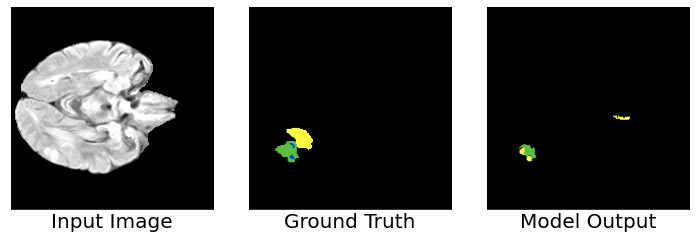

Steps: 5000, L_xent:0.10765722393989563, L_dice: 0.18531471490859985
Total Loss: 0.2929719388484955
Accurary: 0.9861000180244446
Seq: TC, ET, WT
Dice coefficient: [0.9485776144266128, 0.9421552288532257, 0.9057184096177419]
Gradient min:-0.10084445029497147, max:0.15813371539115906
Compute time per epochs: 63.69 mins

Epochs 15



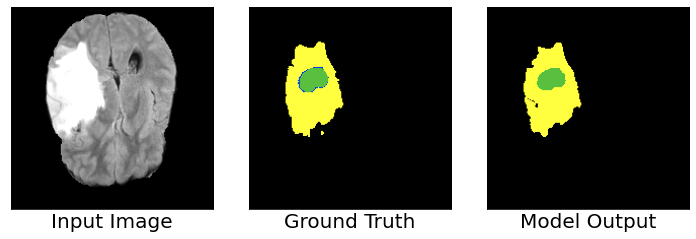

Steps: 5000, L_xent:0.07593898475170135, L_dice: 0.12045919895172119
Total Loss: 0.19639818370342255
Accurary: 0.9914249777793884
Seq: TC, ET, WT
Dice coefficient: [0.9306106050312519, 0.9862212100625039, 0.9394361586372058]
Gradient min:-0.09626415371894836, max:0.07174573838710785
Compute time per epochs: 77.06 mins

Epochs 16



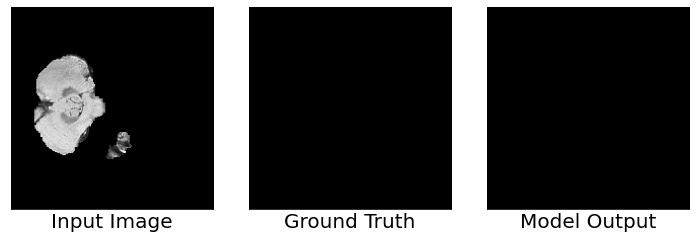

Steps: 5000, L_xent:0.04233430325984955, L_dice: 1.0
Total Loss: 1.0423343181610107
Accurary: 1.0
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 1.0]
Gradient min:-0.055086079984903336, max:0.04253590479493141
Compute time per epochs: 63.89 mins

Epochs 17



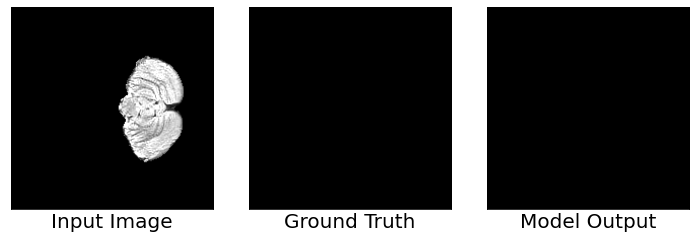

Steps: 5000, L_xent:0.040598850697278976, L_dice: 0.2876700758934021
Total Loss: 0.3282689154148102
Accurary: 1.0
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 1.0]
Gradient min:-0.07123055309057236, max:0.059821173548698425
Compute time per epochs: 63.81 mins

Epochs 18



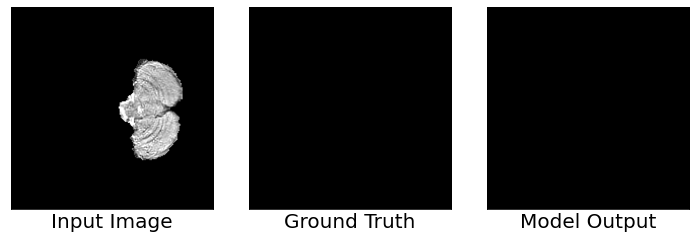

Steps: 5000, L_xent:0.08464376628398895, L_dice: 0.18506336212158203
Total Loss: 0.2697071433067322
Accurary: 1.0
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 1.0]
Gradient min:-0.039859022945165634, max:0.02844127267599106
Compute time per epochs: 63.67 mins

Epochs 19



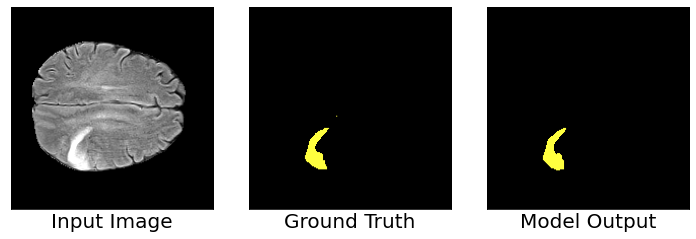

Steps: 5000, L_xent:0.16878297924995422, L_dice: 0.16543960571289062
Total Loss: 0.33422258496284485
Accurary: 0.9988499879837036
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 0.9935146992405256]
Gradient min:-0.09497123956680298, max:0.08500417321920395
Compute time per epochs: 63.69 mins

Epochs 20



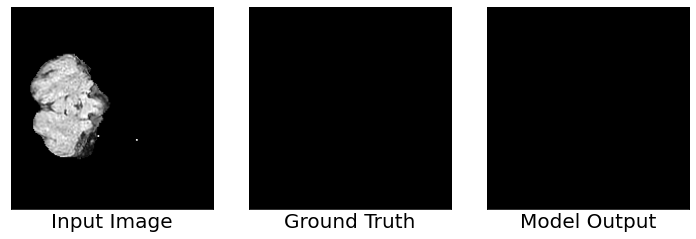

Steps: 5000, L_xent:0.0511542409658432, L_dice: 0.639397919178009
Total Loss: 0.6905521750450134
Accurary: 1.0
Seq: TC, ET, WT
Dice coefficient: [1.0, 1.0, 1.0]
Gradient min:-0.11863060295581818, max:0.3634575605392456
Compute time per epochs: 77.55 mins

----------------------------------<END>---------------------------------
Total run time for 20 epochs: 1329.02 mins


In [8]:
pre_epochs = 0
max_epochs = 20
#remainder epochs 
re_epochs = max_epochs - pre_epochs 
if pre_epochs!=0:
    model.load_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))
    upp_bound = re_epochs
else:
    upp_bound = max_epochs
    
epochs = 1
#list
loss_list = []
start_runtime = time.time()
while epochs <= upp_bound:
    start = time.time()
    print()
    print("Epochs {:2d}".format(epochs))
    steps = 1
    ds = os.listdir(tfrecords_read_dir)
    #shuffle directory list of tfrecords
    shuffle = random.shuffle(ds)
    loss_inner = []
    for tf_re in ds:
        tf_dir = os.path.join(tfrecords_read_dir+tf_re)
        dataset = utils.parse_tfrecord(tf_dir).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
        for imgs in dataset:
            #data augmentation
            imgs = data_aug(imgs)
            #crop images
            image = imgs[:,20:220,20:220,:4]
            #unprocessed label for plotting (cropped)
            label = imgs[:,20:220,20:220,-1]
            #for simplicity label 4 will be converted to 3 for sparse encoding
            label = tf.where(label==4,3,label)
            label = tf.keras.utils.to_categorical(label, num_classes=4)
            #--------------<training function>----------------------------
            img_seg, loss, gradients = train_fn(image, label) 
            #map from sparse to label
            img_seg = tf.math.argmax(img_seg,-1,output_type=tf.int32)
            label = tf.math.argmax(label,-1,output_type=tf.int32)
            #accuracy of the output values for that batch
            acc = tf.reduce_mean(tf.cast(tf.equal(img_seg,label), tf.float32))
            #store loss total for every steps
            loss_inner.append(loss[-1].numpy())
            #save weights for every 5 epochs 
            if epochs%5==0:
                model.save_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))
            #output
            if steps%5000==0:
                input_img = [image[0,:,:,0], plot_labels_color(label[0]), plot_labels_color(img_seg[0])]
                caption = ['Input Image', 'Ground Truth', 'Model Output']
                plot_comparison(input_img, caption, n_col = 3, figsize=(10,10))
                acc_stp = tf.reduce_mean(tf.cast(tf.equal(img_seg[0],label[0]), tf.float32))
                dc_list_stp =compute_metric_dc(label[0],img_seg[0])
                print("Steps: {}, L_xent:{}, L_dice: {}".format(steps, loss[0].numpy(), loss[1].numpy()))
                print("Total Loss: {}".format(loss[-1].numpy()))
                print("Accurary: {}".format(acc_stp))
                print("Seq: TC, ET, WT")
                print("Dice coefficient: {}".format(dc_list_stp))
                print("Gradient min:{}, max:{}".format(np.min(gradients[0]), np.max(gradients[0])))
            steps+=1
    loss_list.append(np.mean(loss_inner))
    #end time per epochs 
    elapsed_time =(time.time()-start)/60 #unit in mins
    print("Compute time per epochs: {:.2f} mins".format(elapsed_time))
    epochs+=1
#end time for total epochs
elapsed_time_runtime = (time.time()-start_runtime)/60
print()
print('----------------------------------<END>---------------------------------')
print("Total run time for {} epochs: {:.2f} mins".format(epochs-1, elapsed_time_runtime))

---

# Save Weights

In [9]:
model.save_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))

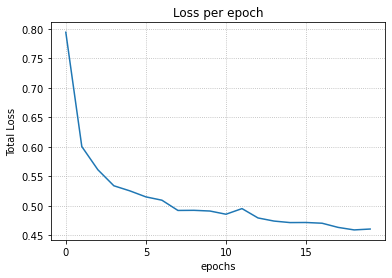

In [28]:
def plot_loss(loss_list, xlabel, ylabel, title, max_epochs):
    '''
    :param loss_list: List containing total loss values
    :param recon_list: List containing reconstruction loss
    :param xlabel: string for xlabel
    :param ylabel: string for ylabel
    :param title: string for title
    :return: loss value plot
    '''
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(np.linspace(0, max_epochs, num=max_epochs//4))
    plt.grid(linestyle='dotted')
    plt.plot(loss_list)

xlabel = 'epochs'
ylabel = 'Total Loss'
title = 'Loss per epoch'
plot_loss(loss_list, xlabel, ylabel, title, upp_bound)

---

# Validation 

In [11]:
model.load_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))
def output_fn(image):
    b,w,h,c = image.shape
    model.trainable = False
    _, model_output,_,_ = model(image)
    # we need [240,240,155] to input into cloud validation
    if w!=240:
        #padding constant
        p = int(240-w)//2
        padding = tf.constant([[0,0],[p,p],[p,p],[0,0]]) #p=20
        model_output = tf.pad(model_output, padding, "CONSTANT")
    return model_output

In [12]:
ds = '/home/kevinteng/Desktop/ssd02/BraTS2020_preprocessed05/'
save_path = '/home/kevinteng/Desktop/ssd02/submission/'
actual_label = '/home/kevinteng/Desktop/ssd02/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii.gz'
#all brain affine are the same just pick one 
brain_affine = nib.load(actual_label).affine
for train_or_val in sorted(os.listdir(ds)):
    save_dir = save_path + train_or_val+'_'+ver
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    merge01 = os.path.join(ds+train_or_val)
    for patient in sorted(os.listdir(merge01)):
        patient_id = patient.split('.')[0]
        merge02 = os.path.join(merge01,patient)
        imgs = np.load(merge02)
        image = imgs[:,20:220,20:220,:4]
        seg_output = 0 #flush RAM
        seg_output = np.zeros((240,240,155))
        for i in range(image.shape[0]):
            inp = tf.expand_dims(image[i],0)
            img_seg = output_fn(inp) #validation function 
            #map from sparse to label
            seg_output[:,:,i] = np.argmax(img_seg,-1) 
        #convert label from 4 to 3 and np array and cast as int
        seg_output= np.where(seg_output==3,4,seg_output).astype(np.uint8)
        prediction_ni = nib.Nifti1Image(seg_output, brain_affine)
        prediction_ni.to_filename(save_dir+'/{}.nii.gz'.format(patient_id))

---

# Model Summary

In [13]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 4) 0                                            
__________________________________________________________________________________________________
gaussian_noise (GaussianNoise)  (None, 200, 200, 4)  0           input_1[0][0]                    
__________________________________________________________________________________________________
coord_conv (CoordConv)          (None, 200, 200, 64) 3520        gaussian_noise[0][0]             
__________________________________________________________________________________________________
group_normalization (GroupNorma (None, 200, 200, 64) 128         coord_conv[0][0]                 
_______________________________________________________________________________________